# Stable Diffusion 深度剖析

Stable Diffusion 是一款强大的文本生成图像模型。市面上有多种网站和工具可帮助你轻松使用它。该模型也已[集成进 Hugging Face 的 diffusers 库](https://huggingface.co/blog/stable_diffusion)，只需几行代码即可生成图像：

```python
from diffusers import StableDiffusionPipeline
pipe = StableDiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1-base",
    variant="fp16",
    torch_dtype=torch.float16,
).to("cuda")
image = pipe("An astronaut scuba diving").images[0]
```

在本笔记本中，我们将深入剖析这些易用接口背后的代码，了解其内部工作原理。首先，我们会把上面的简洁示例“拆解”成一段看似可怕的大块代码；接着，我们将逐一检视不同的组件，弄清它们的职责与作用。等到笔记本结束时，你应该能够随心所欲地调整与改写。


In [1]:
from base64 import b64encode

import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import os

torch.manual_seed(1)

# 忽略加载 CLIPTextModel 时的多余警告
logging.set_verbosity_error()

# 根据硬件环境选择设备：优先使用 CUDA，其次 MPS，否则 CPU
torch_device = "cuda" if torch.cuda.is_available() \
    else "mps" if torch.backends.mps.is_available() \
    else "cpu"
# 如果是 MPS 设备，则开启后备机制以兼容更多操作
if torch_device == "mps":
    os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"

## 加载模型

以下代码（以及下一节的代码）修改自 [Hugging Face 示例笔记本](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb)。

它将下载并设置我们将使用的相关模型和组件。现在先直接运行，然后移动到下一节，确认一切正常后再深入学习细节。

如果你已经加载了 pipeline，也可以通过 `pipe.unet`、`pipe.vae` 等方式访问其中的组件。

在本笔记本中，我们并未使用任何显存优化技巧——如果你的 GPU 显存不足，可以查看 pipeline 代码，参考诸如 **attention slicing**、切换到半精度（fp16）、将 VAE 留在 CPU 等方法来节省内存。


In [2]:
# 加载用于将潜变量解码为图像空间的自编码器模型
vae = AutoencoderKL.from_pretrained(
    "stabilityai/stable-diffusion-2-1-base",
    subfolder="vae"
)
# 加载分词器和文本编码器，用于将文本进行分词和编码
tokenizer = CLIPTokenizer.from_pretrained(
    "stabilityai/stable-diffusion-2-1-base",
    subfolder="tokenizer"
)
text_encoder = CLIPTextModel.from_pretrained(
    "stabilityai/stable-diffusion-2-1-base",
    subfolder="text_encoder"
)

# 加载用于生成潜变量的 UNet 条件模型
unet = UNet2DConditionModel.from_pretrained(
    "stabilityai/stable-diffusion-2-1-base",
    subfolder="unet"
)

# 配置噪声调度器，使用 LMS 离散调度器
scheduler = LMSDiscreteScheduler(
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    num_train_timesteps=1000
)

# 将模型移动到 GPU（或指定的设备）
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)


## 扩散循环（diffusion loop）

如果你只想用文本生成一张图片，可以跳过本笔记本，直接使用现成的工具（例如 [DreamStudio](https://beta.dreamstudio.ai/)），或参考 [此处](https://huggingface.co/blog/stable_diffusion) 的文档，使用 Hugging Face 提供的简化 pipeline。

在本笔记本中，我们希望更深入地了解其工作原理。这段代码改编自 [HF 官方笔记本](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb)，与你查看 [stable diffusion pipeline 中 `__call__()` 方法](https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py#L200) 时看到的内容非常相似。


d:\Users\yin-pu\miniconda3\Lib\site-packages\transformers\models\clip\modeling_clip.py:546: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
C:\Users\yin-pu\AppData\Local\Temp\ipykernel_26572\2568662949.py:43: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

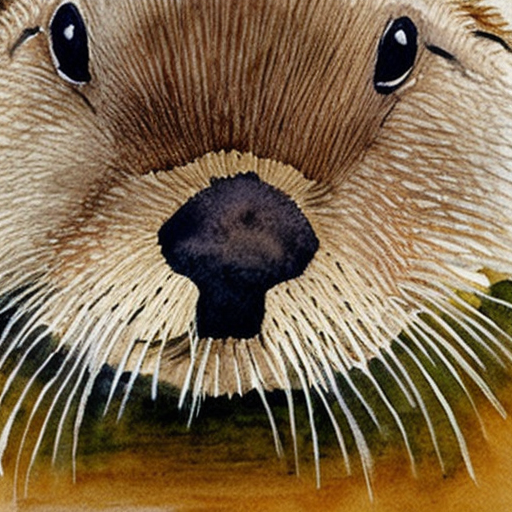

In [3]:
# 配置
prompt = ["A watercolor painting of an otter"]  
height = 512                        # Stable Diffusion 默认图像高度
width = 512                         # Stable Diffusion 默认图像宽度
num_inference_steps = 30            # 去噪步骤数量
guidance_scale = 7.5                # 无分类器指导强度
generator = torch.manual_seed(32)   # 设置随机种子，确保初始潜在噪声可复现
batch_size = 1                      # 批量大小

# 文本预处理：将提示编码为文本嵌入
text_input = tokenizer(
    prompt,
    padding="max_length", 
    max_length=tokenizer.model_max_length, 
    truncation=True, 
    return_tensors="pt"
)
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]

# 准备无条件（empty）文本嵌入，用于 classifier-free guidance
uncond_input = tokenizer(
    [""] * batch_size, 
    padding="max_length", 
    max_length=max_length, 
    return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
# 将无条件和有条件嵌入拼接
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# 调度器预处理：设置时间步长，并转换为 float32 以保证 MPS 兼容
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32)

set_timesteps(scheduler, num_inference_steps)

# 准备初始潜在变量（latent），并按调度器的初始噪声标准差缩放
latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

# 主循环：在所有时间步中迭代去噪
with autocast("cuda"):  # CUDA 上启用自动混合精度；如果不支持则回退到 CPU
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # 为 classifier-free guidance 扩展潜在变量，避免双次前向传播
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]

        # 按调度器方法对模型输入进行缩放（预处理）
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # 预测噪声残差
        with torch.no_grad():
            noise_pred = unet(
                latent_model_input, 
                t, 
                encoder_hidden_states=text_embeddings
            ).sample

        # 应用引导：结合无条件和有条件预测
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # 根据调度器步骤计算上一个潜在样本 x_t -> x_{t-1}
        latents = scheduler.step(noise_pred, t, latents).prev_sample

# 对潜在变量进行缩放并解码为图像
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

# 将图像张量转换为可显示格式，并以 PIL 图像列表返回
image = (image / 2 + 0.5).clamp(0, 1)            # 归一化到 [0,1]
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")   # 转换到 [0,255] 并转为 uint8
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]


代码运行正常，但这段代码可真不少！让我们逐一查看各个组件。


## Autoencoder（AE）

Autoencoder 能够将一张图像**编码**（encode）为某种潜空间表示，再**解码**（decode）回图像。下面我把相关代码封装成了几个函数，以便我们直观地观察其工作流程：


In [4]:
def pil_to_latent(input_im):
    # 将单张 PIL 图像转换为 VAE 的潜在表示（batch 大小为 1，通道数为 4，高度和宽度均为 64）
    with torch.no_grad():
        # 先将 PIL 图像转换为 Tensor 并添加 batch 维度，然后移动到指定设备
        # 将像素值从 [0,1] 缩放到 [-1,1] 区间
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device) * 2 - 1)
    # 从潜在分布中采样，并按比例缩放到稳定范围
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # 将一批 VAE 潜在表示转换回 PIL 图像列表
    # 先将尺度还原到原始潜在空间
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        # 解码潜在表示，得到输出分布的采样
        image = vae.decode(latents).sample
    # 将像素值从 [-1,1] 映射回 [0,1]，并裁剪到有效区间
    image = (image / 2 + 0.5).clamp(0, 1)
    # 从 GPU 拉回 CPU，调整维度顺序为 (batch, 高, 宽, 通道)，并转为 NumPy 数组
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    # 将像素值映射到 [0,255] 的整数，并转换为 uint8 格式
    images = (image * 255).round().astype("uint8")
    # 将每张 NumPy 图像数组转换为 PIL.Image 对象
    pil_images = [Image.fromarray(img) for img in images]
    return pil_images


此处我们将使用一张图片；如果你想使用自己的图片，在下一单元中将文件名修改为对应的图片名。


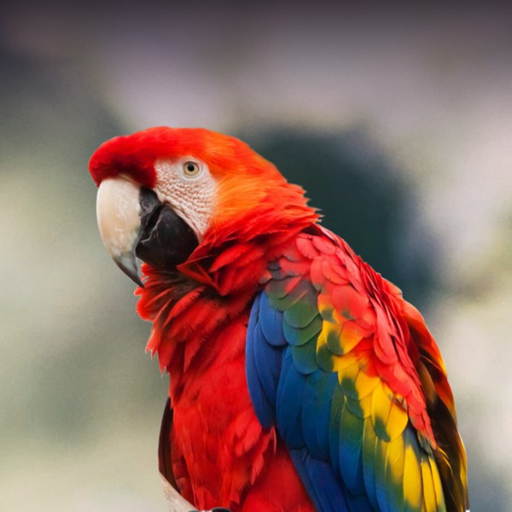

In [5]:
input_image = Image.open('assets/Scarlet-Macaw-2.jpg').resize((512, 512))
input_image

In [6]:
# 转换为潜在表示
encoded = pil_to_latent(input_image)
encoded.shape

torch.Size([1, 4, 64, 64])

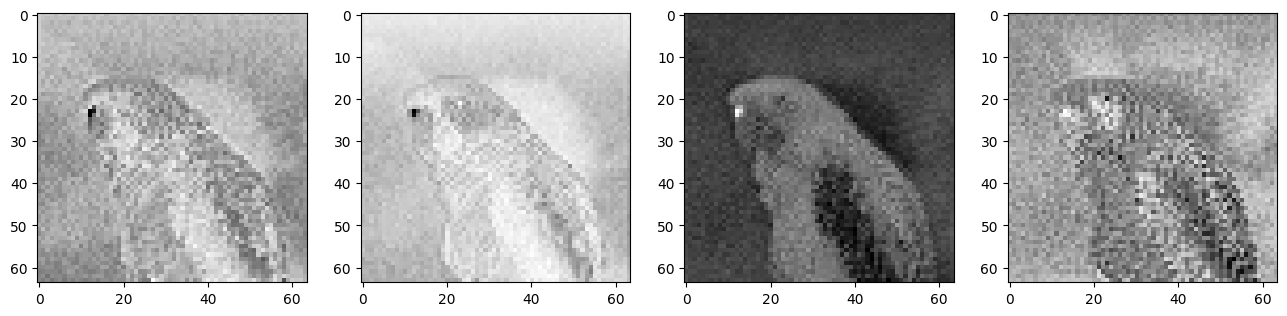

In [7]:
# 可视化这个潜在表示的四个通道
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    # 将第一个样本的第 c 个通道从 GPU 拷贝到 CPU，并以灰度图显示
    axs[c].imshow(encoded[0][c].cpu(), cmap='Greys')


这个 4×64×64 的张量包含了图像的大量信息；当我们将它输入解码器时，理想情况下能够重建出与原始图像几乎一致的结果：


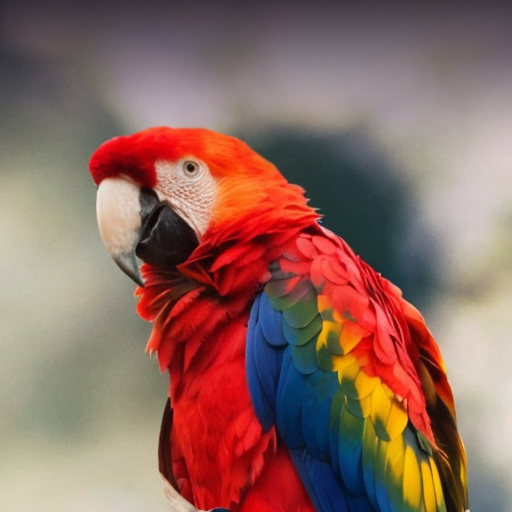

In [8]:
# 可视化解码后的图像
decoded = latents_to_pil(encoded)[0]
decoded 


如果你仔细观察（尤其盯着眼睛看），仍能发现一些细微差别！令人惊叹的是——4 × 64 × 64 的 latent 竟然比一张 64 px 的图像蕴含更多信息……

这个 autoencoder（AE）经过训练，可以把图像压缩成更小的表示，再从压缩后的版本重建原图。

在本例中，压缩倍率约为 48：我们从一张 3 × 512 × 512（ch × ht × wd）的图像开始，它被压缩成一个 4 × 64 × 64 的 latent 向量。换言之，输入图像中每个 3 × 8 × 8 的像素体积最终只用 4 个数（4 × 1 × 1）来表示。你也能找到压缩率更高的 AE（例如某些流行的 VQGAN f16 变体），但压缩过高往往会引入不希望出现的伪影。

**那为什么还要用 autoencoder 呢？**  
我们完全可以在像素空间做扩散——模型直接接收全部像素数据并输出同尺寸的预测。但这样要处理的数据量巨大，高分辨率生成的计算成本非常高。常见的一个解决方案是在低分辨率（比如 64 px）做扩散，再训练单独的模型多次放大（如 D2 / Imagen）。而 **latent diffusion** 则改为在「latent space」中执行扩散，利用 AE 压缩后的表示而不是原始图像：这些表示信息量大，却足够小，能在消费级硬件上轻松处理。当我们生成完新的 latent 表示后，autoencoder 会把它们解码成真正的像素图像。


# Scheduler（调度器）

接下来我们需要讨论如何**添加噪声**……

在训练期间，我们会向图像中注入一些噪声，然后让模型去预测这部分噪声。如果总是一次性加入大量噪声，模型可能几乎无从下手；如果只加入极少量噪声，模型又难以利用我们在采样时使用的随机起点。因此，训练阶段会按照某种分布动态调整噪声量。

在采样阶段，我们希望通过多步“去噪”逐渐得到清晰图像。**步数**以及**每一步的目标噪声量**都会影响最终效果。

这些细节都由 **Scheduler** 负责管理。例如，下面这行代码

```python
scheduler = LMSDiscreteScheduler(
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    num_train_timesteps=1000
)
```

创建了与模型训练时使用的同款 scheduler。当我们想用更少的步数来采样时，可以通过 scheduler.set_timesteps 来重新设定时间步长：

```python
scheduler.set_timesteps(50)  # 将采样步数设为 50
```


In [10]:
# 设置采样步数为 15：
set_timesteps(scheduler, 15)

# 以原始用于训练的 1000 步为基准查看这些步数：
print(scheduler.timesteps)

# 查看对应的噪声水平：
print(scheduler.sigmas)


tensor([999.0000, 927.6429, 856.2857, 784.9286, 713.5714, 642.2143, 570.8571,
        499.5000, 428.1429, 356.7857, 285.4286, 214.0714, 142.7143,  71.3571,
          0.0000])
tensor([14.6146,  9.6826,  6.6780,  4.7746,  3.5221,  2.6666,  2.0606,  1.6156,
         1.2768,  1.0097,  0.7913,  0.6056,  0.4397,  0.2780,  0.0292,  0.0000])


在采样过程中，我们将从一个高噪声水平开始（实际上，输入是纯噪声），并按照这张 **schedule** 的步骤逐步“去噪”直至生成图像。


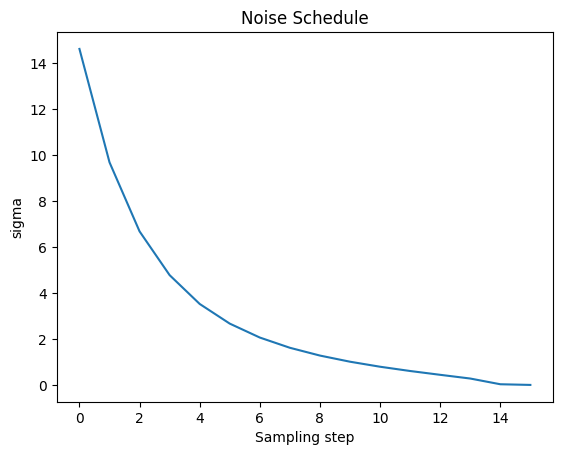

In [11]:
plt.plot(scheduler.sigmas)
plt.title('Noise Schedule')
plt.xlabel('Sampling step')
plt.ylabel('sigma')
plt.show()

“sigma” 表示加入到潜表示中的噪声量。让我们通过给已编码图像添加少量噪声，再将其解码来可视化这一效果：


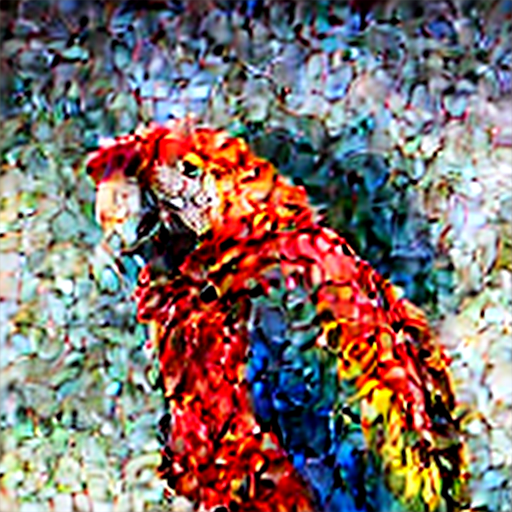

In [14]:
# 生成与 encoded 张量相同形状的随机噪声
noise = torch.randn_like(encoded)

# 在总共 15 个步骤的调度中，选择第 10 步进行采样
sampling_step = 10

# 将噪声添加到编码后的潜在表示中
# 对于 Diffusers 0.3 及以下版本，可以使用：
# encoded_and_noised = scheduler.add_noise(encoded, noise, timestep)
encoded_and_noised = scheduler.add_noise(
    encoded,
    noise,
    timesteps=torch.tensor([scheduler.timesteps[sampling_step]])
)

# 将添加了噪声的潜在表示转换为 PIL 图像，并显示第一张
latents_to_pil(encoded_and_noised.float())[0]  # Display


不同时间步 (timestep) 下会是什么样子呢？动手实验一下，亲自看看吧！

如果你取消注释下面的代码单元，你会发现此处 `scheduler.add_noise` 函数的实现实际上非常直接：它按 sigma 的比例将噪声叠加到原始样本上：

```python
noisy_samples = original_samples + noise * sigmas
```

In [79]:
# ??scheduler.add_noise

其他扩散模型在训练时会用不同的加噪和调度方法。有些做法会通过各种缩放、混合技巧，让不同噪声级别下的**方差几乎保持不变**（叫做 *variance preserving*，VP）；而有些做法则让潜变量随着加噪声方差越滚越大（称为 *variance exploding*，VE）。

---

如果我们想从**纯随机噪声**开始，而不是从已经加过噪的图像开始，就需要先把噪声乘上训练时用到的**最大 σ**（本例约为 14）。接着，在把这些 noisy latents 输入模型之前，还要做一次所谓的 *pre-conditioning* 缩放：

```python
latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)
latent_model_input = scheduler.scale_model_input(latent_model_input, t)
```


## 从加入噪声的输入开始的采样循环（也叫做 image2image）

让我们使用一张已有图像作为起点，先向其中加入一定噪声，然后用新的提示词在循环中仅执行最后几步去噪，看看会发生什么。

我们将采用与第一个示例类似的循环，但会跳过前 `start_step` 步。

为了给图像加噪声，我们将使用上面的示例代码，通过 scheduler 将图像噪声化到与第 10 步（`start_step`）相当的水平。


  0%|          | 0/50 [00:00<?, ?it/s]

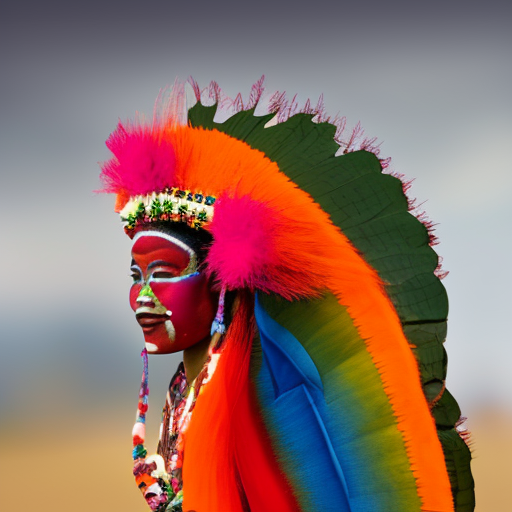

In [17]:
# 设置（与之前相同，仅修改了新的提示词）
prompt = ["A colorful dancer, nat geo photo"]
height = 512                        # Stable Diffusion 默认高度
width = 512                         # Stable Diffusion 默认宽度
num_inference_steps = 50            # 去噪步骤数
guidance_scale = 8                  # 无分类器指导的比例
generator = torch.manual_seed(32)   # 设置随机种子以生成初始潜在噪声
batch_size = 1

# 文本预处理（与之前相同）
text_input = tokenizer(
    prompt,
    padding="max_length",
    max_length=tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt"
)
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size,
    padding="max_length",
    max_length=max_length,
    return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# 调度器准备（设置去噪步数）
set_timesteps(scheduler, num_inference_steps)

# 潜在向量准备（对 start_step 进行适当加噪）
start_step = 10
start_sigma = scheduler.sigmas[start_step]
noise = torch.randn_like(encoded)
latents = scheduler.add_noise(
    encoded,
    noise,
    timesteps=torch.tensor([scheduler.timesteps[start_step]])
)
latents = latents.to(torch_device).float()

# 主循环
for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    if i >= start_step:  # << 这是我们对循环所做的唯一修改

        # 如果使用无分类器指导，将潜在向量复制两份以避免两次前向传播
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # 预测噪声残差
        with torch.no_grad():
            noise_pred = unet(
                latent_model_input,
                t,
                encoder_hidden_states=text_embeddings
            )["sample"]

        # 应用指导
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (
            noise_pred_text - noise_pred_uncond
        )

        # 计算上一步的噪声样本 x_t -> x_{t-1}
        latents = scheduler.step(noise_pred, t, latents).prev_sample

# 将最终潜在向量转换为 PIL 图像并显示第一张
latents_to_pil(latents)[0]


你可以看到，图像中的部分颜色和结构被保留，但我们已经得到了一张全新的图片！添加的噪声越多、采样步数越多，结果就越偏离原始输入图像。

这正是流行的 **img2img pipeline** 的工作原理。如果这就是你的目标，其实已经有很多工具能让流程变得非常简单！

但你也可以发现，底层逻辑与文本生图的采样循环完全一致——只是跳过了最前面的几个步骤，从一张已加噪声的图像，而非纯随机噪声开始。

尝试修改跳过的步数，看看这如何影响输出图像与输入图像的差异程度。  


## 探索文本 → embedding pipeline

我们使用 **text encoder** 模型将文本转换为一组 “embedding”，并将它们作为条件输入扩散模型。下面就跟随一段文本，亲自体验这一流程的工作方式。


In [19]:
# 我们的prompt
prompt = 'A picture of a puppy'

In [20]:
# tokenizer将prompt转换成多个token
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
text_input['input_ids'][0] # View the tokens

tensor([49406,   320,  1674,   539,   320,  6829, 49407,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0])

In [22]:
# 查看单个 token
for t in text_input['input_ids'][0][:8]:  # 我们这里只查看前 8 个，避免大量的 '<|endoftext|>'
    # 打印 token 的 ID 及对应的解码字符
    print(t, tokenizer.decoder.get(int(t)))


tensor(49406) <|startoftext|>
tensor(320) a</w>
tensor(1674) picture</w>
tensor(539) of</w>
tensor(320) a</w>
tensor(6829) puppy</w>
tensor(49407) <|endoftext|>
tensor(0) !


我们可以直接查看最终（输出）embedding，如下所示：

In [23]:
output_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
print('Shape:', output_embeddings.shape)
output_embeddings

Shape: torch.Size([1, 77, 1024])


tensor([[[-0.3134, -0.4476, -0.0082,  ...,  0.2542, -0.0324, -0.2960],
         [ 0.1996, -1.6936, -0.8946,  ...,  0.4658, -0.0956, -2.1484],
         [ 0.6041, -1.2713, -1.7386,  ...,  1.6098,  0.3422, -0.6573],
         ...,
         [ 0.2246, -1.7922, -0.2010,  ..., -0.2742, -0.2052,  0.3401],
         [ 0.2506, -1.8287, -0.1912,  ..., -0.5194, -0.2189,  0.4959],
         [ 0.4095, -2.5429, -0.5164,  ..., -0.1493, -0.2197,  0.9095]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

我们把 token 传入 **text_encoder**，就能神奇地得到一组数值，作为条件送入扩散模型。

这些数值是怎样生成的呢？简单来说，token 会先被转换为一组 **input embedding**，随后再经过 transformer 模型得到最终的 **output embedding**。

要得到这些 **input embedding**，其实包含两步——从 `text_encoder.text_model.embeddings` 的结构就能看出这一点：


In [24]:
text_encoder.text_model.embeddings

CLIPTextEmbeddings(
  (token_embedding): Embedding(49408, 1024)
  (position_embedding): Embedding(77, 1024)
)

### Token embeddings

将 token 输入 `token_embedding` 层后，它会被转换成一个向量。这里函数名 `get_input_embeddings` 可能有些误导，因为这些 **token embedding** 在真正作为模型输入之前，还需要与 **position embedding** 相结合！  
无论如何，我们先单独看看 token embedding 这一部分。

我们可以查看 embedding 层：


In [ ]:
token_emb_layer = text_encoder.text_model.embeddings.token_embedding
token_emb_layer # Vocab size 49408, emb_dim 1024

Embedding(49408, 1024)

In [ ]:
# 嵌入一个 token —— 这里以 'puppy' 对应的 token 为例
embedding = token_emb_layer(torch.tensor(6829, device=torch_device))
embedding.shape  # 1024 维向量

torch.Size([1024])

这个单独的 token 被映射为一个 1024 维向量——即 **token embedding**。

对prompt中的所有 token 进行同样的处理，就能得到全部 token 的 embedding：


In [27]:
token_embeddings = token_emb_layer(text_input.input_ids.to(torch_device))
print(token_embeddings.shape)
token_embeddings

torch.Size([1, 77, 1024])


tensor([[[ 0.0004, -0.0038,  0.0039,  ..., -0.0008,  0.0012,  0.0006],
         [ 0.0028, -0.0054, -0.0041,  ..., -0.0032,  0.0083,  0.0027],
         [ 0.0016,  0.0102,  0.0225,  ..., -0.0158, -0.0039,  0.0117],
         ...,
         [-0.0019, -0.0093,  0.0056,  ...,  0.0012, -0.0116,  0.0078],
         [-0.0019, -0.0093,  0.0056,  ...,  0.0012, -0.0116,  0.0078],
         [-0.0019, -0.0093,  0.0056,  ...,  0.0012, -0.0116,  0.0078]]],
       device='cuda:0', grad_fn=<EmbeddingBackward0>)

### 位置嵌入（Positional Embeddings）

位置嵌入告诉模型某个 token 在序列中的位置。与 token embedding 类似，它也是一组（可选可学习的）参数。但不同的是，这里无需为约 5 万个 token 分别建立参数，而只需要为每个位置准备一个嵌入——总共 77 个。  


In [28]:
pos_emb_layer = text_encoder.text_model.embeddings.position_embedding
pos_emb_layer

Embedding(77, 1024)

我们可以得到每个位置的Positional Embedding

In [30]:
position_ids = text_encoder.text_model.embeddings.position_ids[:, :77]
position_embeddings = pos_emb_layer(position_ids)
print(position_embeddings.shape)
position_embeddings

torch.Size([1, 77, 1024])


tensor([[[ 4.2000e-04, -3.7907e-03,  3.8631e-03,  ..., -8.2362e-04,
           1.2371e-03,  5.8403e-04],
         [ 3.8628e-04, -1.3632e-03,  2.3881e-03,  ..., -7.9239e-04,
           2.1081e-03,  1.0945e-04],
         [ 1.2491e-03,  9.7469e-04,  1.9096e-03,  ...,  1.3996e-03,
           1.1849e-03, -9.9053e-04],
         ...,
         [-1.3587e-02, -1.8243e-03,  8.0844e-03,  ...,  5.8177e-03,
          -1.0164e-02, -3.7979e-04],
         [-1.0371e-02,  6.7726e-03,  1.0554e-03,  ...,  1.1578e-05,
          -9.3409e-03, -1.8854e-03],
         [-1.7725e-03, -1.2069e-02, -1.2666e-02,  ...,  9.3059e-03,
           6.6324e-03, -6.0417e-03]]], device='cuda:0',
       grad_fn=<EmbeddingBackward0>)

### 组合 token 与 position embedding

现在把两者结合起来。方法很简单：**直接相加**！虽然还有其他实现方式，但本模型就采用这种方案。

通过如此相加，我们便得到可直接送入 transformer 的最终 **input embedding**：

In [31]:
input_embeddings = token_embeddings + position_embeddings
print(input_embeddings.shape)
input_embeddings

torch.Size([1, 77, 1024])


tensor([[[ 0.0008, -0.0076,  0.0077,  ..., -0.0016,  0.0025,  0.0012],
         [ 0.0032, -0.0067, -0.0017,  ..., -0.0040,  0.0104,  0.0028],
         [ 0.0029,  0.0112,  0.0245,  ..., -0.0144, -0.0027,  0.0107],
         ...,
         [-0.0155, -0.0111,  0.0136,  ...,  0.0070, -0.0218,  0.0074],
         [-0.0122, -0.0025,  0.0066,  ...,  0.0012, -0.0210,  0.0059],
         [-0.0036, -0.0213, -0.0071,  ...,  0.0105, -0.0050,  0.0018]]],
       device='cuda:0', grad_fn=<AddBackward0>)

我们可以验证以下结果是否与直接调用 `text_encoder.text_model.embeddings` 得到的输出一致：




In [32]:
# 这行代码将上面所有步骤整合在一起（不过无法让我们逐步调试！）
text_encoder.text_model.embeddings(text_input.input_ids.to(torch_device))

tensor([[[ 0.0008, -0.0076,  0.0077,  ..., -0.0016,  0.0025,  0.0012],
         [ 0.0032, -0.0067, -0.0017,  ..., -0.0040,  0.0104,  0.0028],
         [ 0.0029,  0.0112,  0.0245,  ..., -0.0144, -0.0027,  0.0107],
         ...,
         [-0.0155, -0.0111,  0.0136,  ...,  0.0070, -0.0218,  0.0074],
         [-0.0122, -0.0025,  0.0066,  ...,  0.0012, -0.0210,  0.0059],
         [-0.0036, -0.0213, -0.0071,  ...,  0.0105, -0.0050,  0.0018]]],
       device='cuda:0', grad_fn=<AddBackward0>)

### 将这些 embedding 输入 transformer 模型

![transformer diagram](assets/text_encoder_noborder.png)


在把输入 embeddings（特别是 *token embeddings*）传入后续模型之前，我们想先对它们动手脚。不过，在此之前我们得确认自己知道该怎么做。我查阅了 `text_encoder` 的 `forward` 方法源码，以及它内部封装的 `text_model` 的 `forward` 方法源码。你也可以自己动手查看：在笔记本里输入 `??text_encoder.text_model.forward`，就会显示该函数的信息与源代码——这可是个非常实用的调试技巧！

有了这些信息，我们就能复制所需的代码片段，取得所谓的 *last hidden state*，从而生成最终的 embeddings：


In [41]:
import transformers
def get_output_embeds(input_embeddings):
    # CLIP 的文本模型使用因果掩码，所以我们在这里构建它：
    bsz, seq_len = input_embeddings.shape[:2]
    causal_attention_mask = transformers.modeling_attn_mask_utils._create_4d_causal_attention_mask(
        (bsz, seq_len), dtype=input_embeddings.dtype, device=torch_device
    )

    # 获取输出嵌入需要调用模型并设置 output_hidden_states=True
    # 这样模型不会只返回池化后的最终预测结果：
    encoder_outputs = text_encoder.text_model.encoder(
        inputs_embeds=input_embeddings,
        attention_mask=None,  # 我们不使用注意力掩码，因此可以设为 None
        causal_attention_mask=causal_attention_mask.to(torch_device),
        output_attentions=None,
        output_hidden_states=True,  # 我们需要输出隐藏状态，而不是最终输出
        return_dict=None,
    )

    # 我们只关心输出的隐藏状态
    output = encoder_outputs[0]

    # 需要通过一个最终的 layer norm 层
    output = text_encoder.text_model.final_layer_norm(output)

    # 现在嵌入已经准备好了！
    return output

out_embs_test = get_output_embeds(input_embeddings)  # 使用我们新写的函数传入模型
print(out_embs_test.shape)  # 检查输出的形状
out_embs_test  # 查看输出结果


torch.Size([1, 77, 1024])


tensor([[[-0.3134, -0.4476, -0.0082,  ...,  0.2542, -0.0324, -0.2960],
         [ 0.1996, -1.6936, -0.8946,  ...,  0.4658, -0.0956, -2.1484],
         [ 0.6041, -1.2713, -1.7386,  ...,  1.6098,  0.3422, -0.6573],
         ...,
         [ 0.2246, -1.7922, -0.2010,  ..., -0.2742, -0.2052,  0.3401],
         [ 0.2506, -1.8287, -0.1912,  ..., -0.5194, -0.2189,  0.4959],
         [ 0.4095, -2.5429, -0.5164,  ..., -0.1493, -0.2197,  0.9095]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

请注意，这些结果与我们在开头看到的 `output_embeddings` 一致——也就是说，我们已经成功地把“获取文本嵌入”这一整体步骤拆分成了多个可供修改的子步骤。

在此基础上，我们可以将某个 token 的输入嵌入替换为自己选择的新嵌入——在最终的应用场景中，这个新嵌入可能来自于我们训练得到的内容。为了演示这个概念，让我们把提示词中的 **“puppy”** 的输入嵌入替换为 **token 2368** 的嵌入，重新得到一组输出嵌入，并用它们来生成图像，看看会得到什么结果：


In [43]:
prompt = 'A picture of a puppy'

# 对prompt进行分词，填充到模型最大长度，超过则截断
text_input = tokenizer(
    prompt, 
    padding="max_length", 
    max_length=tokenizer.model_max_length, 
    truncation=True, 
    return_tensors="pt"
)
input_ids = text_input.input_ids.to(torch_device)

# 获取各 token 的嵌入向量
token_embeddings = token_emb_layer(input_ids)

# 新的替换 token 嵌入（这里示例中直接取编号为 2368 的 token 对应的输入嵌入）
replacement_token_embedding = text_encoder.get_input_embeddings()(
    torch.tensor(2368, device=torch_device)
)

# 将原始嵌入中 ID 为 6829 的位置替换为新的嵌入
token_embeddings[0, torch.where(input_ids[0] == 6829)] = replacement_token_embedding.to(torch_device)

# 与位置嵌入相加，形成最终的输入嵌入
input_embeddings = token_embeddings + position_embeddings

# 将修改后的输入嵌入送入后续网络，获取输出嵌入
modified_output_embeddings = get_output_embeds(input_embeddings)

# 打印输出嵌入的形状，并显示具体数值
print(modified_output_embeddings.shape)
modified_output_embeddings


torch.Size([1, 77, 1024])


tensor([[[-0.3134, -0.4476, -0.0082,  ...,  0.2542, -0.0324, -0.2960],
         [ 0.1996, -1.6936, -0.8946,  ...,  0.4658, -0.0956, -2.1484],
         [ 0.6041, -1.2713, -1.7386,  ...,  1.6098,  0.3422, -0.6573],
         ...,
         [ 0.3091, -1.5752, -0.0421,  ..., -0.1675, -0.0415,  0.2474],
         [ 0.3601, -1.6129, -0.0410,  ..., -0.4279, -0.0621,  0.4225],
         [ 0.4704, -2.3738, -0.4211,  ..., -0.1271, -0.1751,  0.7595]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

前几个 token 保持不变，最后几个则产生了差异。从我们替换的那个 token 位置开始及其之后的所有内容都会受到影响。

如果一切顺利，当我们用这些 embedding 去生成图像时，应该会得到不是小狗的其他内容——结果果然如此！


In [44]:
# 使用这些修改后的嵌入向量生成图像

def generate_with_embs(text_embeddings):
    height = 512                        # Stable Diffusion 的默认高度
    width = 512                         # Stable Diffusion 的默认宽度
    num_inference_steps = 30            # 去噪步骤数量
    guidance_scale = 7.5                # 无分类器引导的权重比例
    generator = torch.manual_seed(32)   # 设置随机种子以生成初始潜在噪声
    batch_size = 1                      # 批量大小

    max_length = text_input.input_ids.shape[-1]  # 文本输入的最大长度
    # 构造空的无条件输入，用于 classifier-free guidance
    uncond_input = tokenizer(
      [""] * batch_size,
      padding="max_length",
      max_length=max_length,
      return_tensors="pt"
    )
    with torch.no_grad():
        # 获取无条件文本嵌入
        uncond_embeddings = text_encoder(
            uncond_input.input_ids.to(torch_device)
        )[0]
    # 将无条件和条件嵌入拼接
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # 配置调度器的时间步
    set_timesteps(scheduler, num_inference_steps)

    # 初始化潜在张量
    latents = torch.randn(
        (batch_size, unet.in_channels, height // 8, width // 8),
        generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma  # 应用初始噪声幅度

    # 迭代去噪循环
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # 如果使用 classifier-free guidance，需要对潜在张量进行扩展以避免两次前向传播
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # 预测噪声残差
        with torch.no_grad():
            noise_pred = unet(
                latent_model_input,
                t,
                encoder_hidden_states=text_embeddings
            )["sample"]

        # 应用引导：无条件预测 + scale * (条件预测 - 无条件预测)
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # 计算前一步的噪声样本 x_t -> x_{t-1}
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    # 将潜在张量转换为 PIL 图像并返回第一张
    return latents_to_pil(latents)[0]


C:\Users\yin-pu\AppData\Local\Temp\ipykernel_26572\1855381419.py:32: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

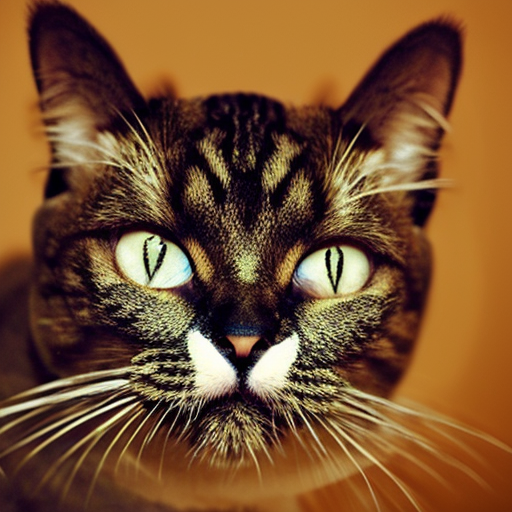

In [45]:
generate_with_embs(modified_output_embeddings)

惊喜！现在你已经知道 token 2368 的含义了 😉

**我们能用它做什么？** 为什么要费这么大劲？稍后你会看到更有说服力的用例，但是：一旦能够访问并修改 token embedding，就能把它们替换成其他内容。在刚才的示例中，我们只是用模型词表中的另一个 token embedding 进行替换，相当于直接编辑提示词。不过我们还可以混合多个 token —— 例如，下面就是一个半小狗、半臭鼬的案例：


In [46]:
# 如果你想知道如何获取一个单词的 token，或获取一个 token 的嵌入：
prompt = 'skunk'

# 打印将 prompt 编码为 token id 的结果
print('tokenizer(prompt):', tokenizer(prompt))

# 打印 token 嵌入层对给定 token id 输出的形状，这里以 token id 8797 为例
print('token_emb_layer([token_id]) shape:', 
      token_emb_layer(torch.tensor([8797], device=torch_device)).shape)


tokenizer(prompt): {'input_ids': [49406, 42194, 49407], 'attention_mask': [1, 1, 1]}
token_emb_layer([token_id]) shape: torch.Size([1, 1024])


C:\Users\yin-pu\AppData\Local\Temp\ipykernel_26572\1855381419.py:32: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

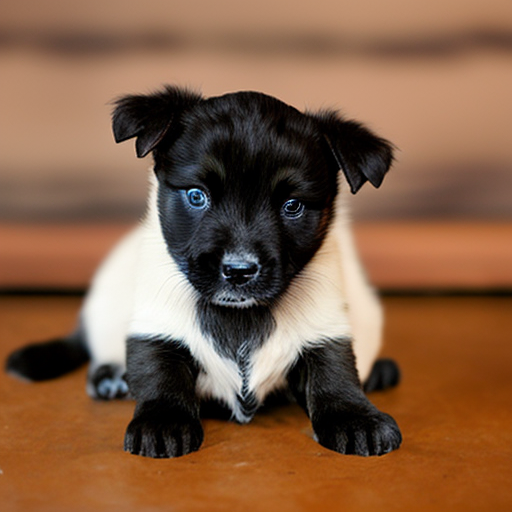

In [47]:
prompt = 'A picture of a puppy'

# 分词，将 prompt 转换为模型输入格式，采用最大长度填充和截断
text_input = tokenizer(
    prompt,
    padding="max_length",
    max_length=tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt"
)
input_ids = text_input.input_ids.to(torch_device)

# 获取原始的 token 嵌入
token_embeddings = token_emb_layer(input_ids)

# 分别获取 'puppy' 和 'skunk' 的 token 嵌入
puppy_token_embedding = token_emb_layer(
    torch.tensor(6829, device=torch_device)
)
skunk_token_embedding = token_emb_layer(
    torch.tensor(42194, device=torch_device)
)

# 将两个 token 嵌入按 0.5:0.5 的比例混合，作为替换嵌入
replacement_token_embedding = 0.5 * puppy_token_embedding + 0.5 * skunk_token_embedding

# 在原始 token 嵌入中找到 'puppy' 的位置，用混合嵌入进行替换
token_embeddings[0, torch.where(input_ids[0] == 6829)] = replacement_token_embedding.to(torch_device)

# 加上位置嵌入，得到最终的输入嵌入
input_embeddings = token_embeddings + position_embeddings

# 将修改后的输入嵌入送入模型，获取输出嵌入
modified_output_embeddings = get_output_embeds(input_embeddings)

# 使用修改后的输出嵌入生成图像
generate_with_embs(modified_output_embeddings)


### Textual Inversion

好的，我们可以插入修改后的 token embedding，并用它来生成图像。上面的示例中，我们使用了 “cat” 的 token embedding，但如果我们能够 **“学习”** 一个特定概念的新 token embedding 会怎样？这正是 **Textual Inversion** 的思路：借助少量示例图像来创建一枚全新的 token embedding。

![来自博客文章的示意图](assets/training.JPG)  
_图片摘自 [Textual Inversion 博客](https://textual-inversion.github.io/static/images/training/training.JPG) —— 为简化示意，图中省略了 positional embeddings 步骤_

本笔记本不会深入讲解该训练过程的细节。


## 玩转 Embeddings

除了仅替换单个单词的 token embedding，我们还可以尝试各种其它技巧。例如，如果我们把两个不同提示词的 embedding 取平均，创造出一个“嵌合体（chimera）”，会发生什么呢？


C:\Users\yin-pu\AppData\Local\Temp\ipykernel_26572\1855381419.py:32: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

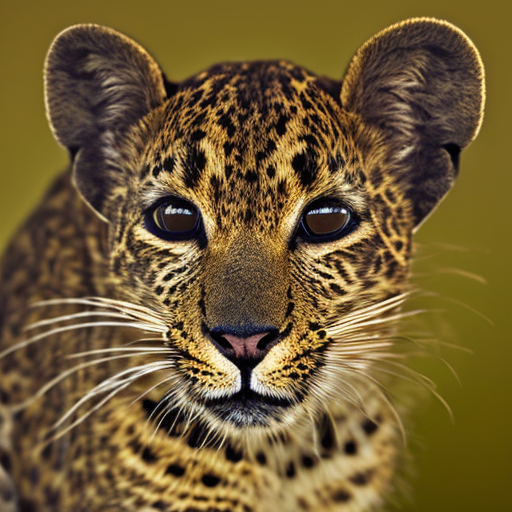

In [64]:
# embedding两个prompt
text_input1 = tokenizer(["A mouse"], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
text_input2 = tokenizer(["A leopard"], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings1 = text_encoder(text_input1.input_ids.to(torch_device))[0]
    text_embeddings2 = text_encoder(text_input2.input_ids.to(torch_device))[0]

# Mix them together
mix_factor = 0.35
mixed_embeddings = (text_embeddings1*mix_factor + \
                   text_embeddings2*(1-mix_factor))

# Generate!
generate_with_embs(mixed_embeddings)

## UNet 与 CFG

现在该看看真正的扩散模型了。它通常是一个 **Unet**，接受带噪潜变量 `x` 并预测噪声。我们使用的是条件模型，它还会将时间步 `t` 和文本嵌入（即 `encoder_hidden_states`）作为条件一并输入。调用方式如下所示：

`noise_pred = unet(latents, t, encoder_hidden_states=text_embeddings)["sample"]`

我们不妨试着运行一下，看看它的输出长什么样：


In [66]:
# 准备调度器
set_timesteps(scheduler, num_inference_steps)

# 获取当前的时间步（timestep）
t = scheduler.timesteps[0]
sigma = scheduler.sigmas[0]

# 生成带噪声的潜在向量 (latent)
latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

# 文本编码（生成文本嵌入）
text_input = tokenizer(
    ['A macaw'],
    padding="max_length",
    max_length=tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt"
)
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

# 通过 U-Net 预测噪声残差
with torch.no_grad():
    noise_pred = unet(
        latents,
        t,
        encoder_hidden_states=text_embeddings
    )["sample"]

# 输出潜在向量和预测噪声的形状，二者形状应相同
latents.shape, noise_pred.shape


C:\Users\yin-pu\AppData\Local\Temp\ipykernel_26572\1749009892.py:10: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


(torch.Size([1, 4, 64, 64]), torch.Size([1, 4, 64, 64]))

给定一组带噪潜变量 (noisy latents)，模型会预测其中的噪声分量。我们可以将噪声从潜向量中扣除（`latents_x0 = latents - sigma * noise_pred`），从而查看输出图像 ($x₀$) 的样子。随后，再把大部分噪声加回到该预测输出，以得到下一次扩散步骤的输入 ($x_{t-1}$) —— 希望此时噪声更少一些。为了直观展示这一过程，我们将再生成一张图，并在每一步都保存预测输出 ($x₀$) 与下一步输入 ($x_{t-1}$)：


In [70]:
import os

os.makedirs('steps', exist_ok=True)

prompt = 'Oil painting of an otter in a top hat'
height = 512  # 生成图像的高度（像素）
width = 512   # 生成图像的宽度（像素）
num_inference_steps = 50  # 推理步骤数
guidance_scale = 8        # 引导强度（classifier-free guidance）
generator = torch.manual_seed(32)  # 随机种子，保证可复现
batch_size = 1  # 每次推理生成的图像数量


# 准备文本输入：对prompt进行分词并填充到最大长度
text_input = tokenizer(
    [prompt],
    padding="max_length",
    max_length=tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt"
)
with torch.no_grad():
    # 获取文本编码器输出的文本嵌入
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

max_length = text_input.input_ids.shape[-1]
# 准备空提示（用于无条件引导）
uncond_input = tokenizer(
    [""] * batch_size,
    padding="max_length",
    max_length=max_length,
    return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

# 将有条件和无条件嵌入拼接在一起
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# 设置调度器的时间步
set_timesteps(scheduler, num_inference_steps)

# 初始化潜在向量（latents），尺寸为 batch_size × 通道数 × (height/8) × (width/8)
latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma  # 按调度器的噪声规模初始化

# 主推理循环：按时间步迭代
for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    # 扩展潜在向量以同时进行无条件和有条件的前向推理
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    # 根据当前时间步调整模型输入
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # 预测噪声残差
    with torch.no_grad():
        noise_pred = unet(
            latent_model_input,
            t,
            encoder_hidden_states=text_embeddings
        )["sample"]

    # 分离无条件和有条件预测，并应用引导
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # 使用调度器计算原始样本 x0 的预测值
    scheduler_step = scheduler.step(noise_pred, t, latents)
    latents_x0 = scheduler_step.pred_original_sample  # Diffusers 0.4+ 接口

    # 计算下一个时间步的潜在向量 x_{t-1}
    latents = scheduler_step.prev_sample

    # 将潜在向量转换为 PIL 图像
    im_t0 = latents_to_pil(latents_x0)[0]  # 预测的干净图像
    im_next = latents_to_pil(latents)[0]   # 下一个时间步的图像

    # 将两张图像拼接并保存，左侧为下一个时间步，右侧为预测干净图像
    im = Image.new('RGB', (1024, 512))
    im.paste(im_next, (0, 0))
    im.paste(im_t0, (512, 0))
    im.save(f'steps/{i:04}.jpeg')


C:\Users\yin-pu\AppData\Local\Temp\ipykernel_26572\178534998.py:45: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/50 [00:00<?, ?it/s]

In [75]:
import glob, io
from PIL import Image
import ipywidgets as widgets
from IPython.display import display

files = sorted(glob.glob('./steps/*.jpeg'))

slider = widgets.IntSlider(value=0, min=0, max=len(files)-1, description='Step')
img_widget = widgets.Image(format='jpeg')

def show_frame(step):
    img = Image.open(files[step])
    b = io.BytesIO()
    img.save(b, format='PNG')
    img_widget.value = b.getvalue()

slider.observe(lambda change: show_frame(change['new']), names='value')
show_frame(0)          # 先显示第 0 帧
display(slider, img_widget)

IntSlider(value=0, description='Step', max=49)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x04\x00\x00\x00\x02\x00\x08\x02\x00\x00\x00\x93\xaf\…

右侧的版本在每一步都会显示预测的「最终输出」（x₀），左侧的版本则显示的是「下一步」的输出。我发现同时对比这两种可视化方式非常有意思——如果只看右侧，你可能会以为在早期阶段就发生了剧烈的变化，但实际上，由于每一步的改动都相对较小，整个生成过程要平滑得多。


### Classifier Free Guidance（无分类器引导）

默认情况下，模型往往不会完全按照我们的要求生成结果。若想让它更好地遵循提示，可以使用一种名为 CFG 的技巧。有关原理的精彩讲解，可参考这段视频（AI coffee break GLIDE）。

在代码层面，其核心公式为：

`noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)`

这一招的效果出乎意料地好 :) 尝试调整上面代码中的 `guidance_scale`，看看结果如何变化。你能把它调多高而不会让生成效果变差呢？


## 采样（Sampling）

在 `latents = scheduler.step(noise_pred, i, latents)["prev_sample"]` 这一行代码里，仍然隐藏着一些复杂细节。采样器究竟是如何把当前嘈杂的潜变量（latents）变成稍微“降噪”后的版本？为什么我们不能一次就用模型完成整个过程？还有别的方式来理解这一点吗？

模型的任务是预测图像中的噪声。当噪声较低时，我们假设模型做得还不错；但在高噪声水平下，它就很难了！于是，直接生成的图像往往只是一团模糊的糊状物——在前面提到的视频开头就能看到这种效果。因此，采样器会利用模型的预测值，让潜变量朝着模型预测的方向小幅移动（去除部分噪声），然后再用这个略微“少废”的输入进行下一次预测，希望通过迭代逐步改进结果。

不同的采样器采取的方法各不相同。想了解默认 LMS 采样器的实现细节，可以尝试阅读它的源码：


In [81]:
# ??scheduler.step

# Guidance

好的，最后一个技巧！如何为生成过程加入更多的可控性呢？

在每一步，我们都会像之前那样使用模型来预测 \(x\) 的噪声分量。接着利用它生成预测的输出图像，并对该图像应用某种 **损失函数**。

这个损失函数可以是任何形式；下面用一个极其简单的例子来演示：如果我们想要生成 **偏蓝** 的图像，可以编写一个损失函数，使得像素的蓝色分量较低时损失更大：


In [80]:
def blue_loss(images):
    # 计算蓝色通道值与 0.9 之间的差距
    # images[:, 2] 表示取出当前批次中所有图像的蓝色通道
    error = torch.abs(images[:, 2] - 0.9).mean()  # 先计算绝对误差，再取平均值
    return error


C:\Users\yin-pu\AppData\Local\Temp\ipykernel_26572\2791483205.py:40: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss: 191.46566772460938
10 loss: 51.08943557739258
20 loss: 24.394012451171875
30 loss: 16.7495174407959
40 loss: 15.939725875854492


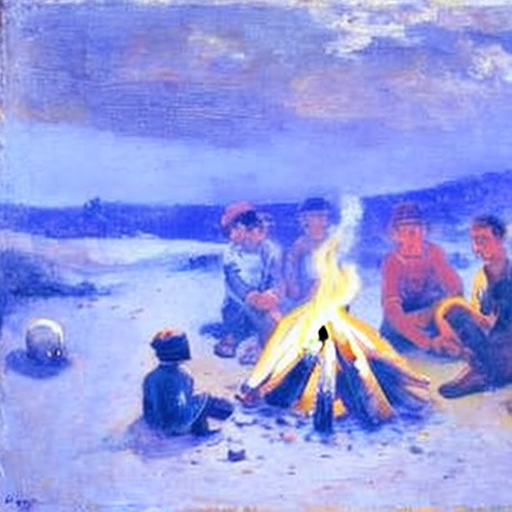

In [82]:
prompt = 'A campfire (oil on canvas)'  
height = 512                        # Stable Diffusion 默认生成图像的高度
width = 512                         # Stable Diffusion 默认生成图像的宽度
num_inference_steps = 50            # 迭代去噪的步数
guidance_scale = 8                  # 无条件引导 (classifier-free guidance) 的权重
generator = torch.manual_seed(32)   # 设置随机种子，用于初始化潜在噪声
batch_size = 1                      # 每次生成的样本数量
blue_loss_scale = 200               # 额外引导损失的放大系数

# 进行分词并转换为模型可接受的张量
text_input = tokenizer(
    [prompt],
    padding="max_length",
    max_length=tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt"
)
with torch.no_grad():
    # 获取文本编码器输出的文本嵌入
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

# 同样准备无条件（empty）文本输入
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size,
    padding="max_length",
    max_length=max_length,
    return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
# 将无条件嵌入与条件嵌入拼接，以供后续 classifier-free guidance 使用
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# 设置调度器的时间步
set_timesteps(scheduler, num_inference_steps)

# 初始化潜变量，尺寸为 (batch_size, 通道数, height/8, width/8)
latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

# 进入迭代去噪循环
for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    # 扩展潜变量以进行 classifier-free guidance，避免重复前向计算
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # 预测噪声残差
    with torch.no_grad():
        noise_pred = unet(
            latent_model_input,
            t,
            encoder_hidden_states=text_embeddings
        )["sample"]

    # 应用 classifier-free guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    #### 额外的自定义引导 ###
    if i % 5 == 0:
        # 使 latents 可计算梯度
        latents = latents.detach().requires_grad_()

        # 基于预测噪声计算去噪后的 x0
        latents_x0 = latents - sigma * noise_pred

        # 解码到图像空间，并将值映射到 (0,1) 区间
        denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5

        # 计算额外引导损失
        loss = blue_loss(denoised_images) * blue_loss_scale

        # 每隔 10 步打印一次损失
        if i % 10 == 0:
            print(i, 'loss:', loss.item())

        # 计算损失关于潜变量的梯度
        cond_grad = torch.autograd.grad(loss, latents)[0]

        # 基于梯度调整潜变量
        latents = latents.detach() - cond_grad * sigma**2

    # 调度器执行一步，更新潜变量
    latents = scheduler.step(noise_pred, t, latents).prev_sample

# 将最终潜变量转换为 PIL 图像并显示第一张
latents_to_pil(latents)[0]


调整 `blue_loss_scale` 的数值 —— 当该值较低时，受提示词影响，生成的图像主要呈红色和橙色；当数值提高时，图像则趋向蓝色；若过高，则可能出现一整张纯蓝图像。

由于这一过程较慢，你会注意到我仅在每 5 次迭代时才应用一次该损失项——这是 Jeremy 的建议。我们在此示例中保留这一做法，因为它能够节省时间且效果依旧良好。进行个人实验时，你也可以尝试降低损失权重并在每次迭代都应用它 :)


**注意**：如果想获得更精确的梯度，应在对 UNet 做前向传播之前，将 `latents.requires_grad = True`（并移除 `with torch.no_grad()`）。但这会显著增加显存占用。你会在不同的实现中看到两种做法的权衡取舍。

使用**分类器模型**进行引导，可以让生成图像偏向某个特定类别；使用类似 **CLIP** 的模型进行引导，则能让结果与文本提示更契合；使用**风格损失**进行引导，可以注入指定的艺术风格；使用某种**感知损失**进行引导，则能让图像整体更接近目标图像的外观……以此类推。


# 总结

希望现在你对使用这些模型生成图像时内部发生的过程，以及如何以富有创意的方式修改该流程，有了更深入的了解。也期待这能激发你创作出有趣的作品 😊

